In [19]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import cv2

import keras
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D


In [12]:
#Preproccess data

#read in csv files
csv_path = 'chest_xrays_files/csv_files/'
df_image_id = pd.read_csv(csv_path + 'nih-cxr-lt_image_ids.csv')
df_label_train = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_train.csv')
df_label_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_test.csv')
df_balanced_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-test.csv')
df_balanced_val = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-val.csv')
#there are 5 files:
#all image ids
#balanced testing dataset
#balanced validation dataset
#normal testing dataset
#normal training dataset

#fixing naming convention of a columns
df_label_train.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_train.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_train.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_train.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_label_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_val.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_val.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)

#create new dataframes that contain solely heart issues
#include columns only with heart related labels
#remove rows where all values are zero (no finding == 0 -> condition)
#cant do one liner for dropping so have to use conditional drop
df_label_train_heart = df_label_train[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_train_heart = df_label_train_heart.drop(df_label_train_heart[(df_label_train_heart.Cardiomegaly == 0) & (df_label_train_heart.Infiltration == 0) & (df_label_train_heart.Mass == 0) & (df_label_train_heart.Nodule == 0) & (df_label_train_heart.Tortuous_Aorta == 0) & (df_label_train_heart.Calcification_of_the_Aorta == 0) & (df_label_train_heart.No_Finding == 0) ].index)
df_label_test_heart = df_label_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_test_heart = df_label_test_heart.drop(df_label_test_heart[(df_label_test_heart.Cardiomegaly == 0) & (df_label_test_heart.Infiltration == 0) & (df_label_test_heart.Mass == 0) & (df_label_test_heart.Nodule == 0) & (df_label_test_heart.Tortuous_Aorta == 0) & (df_label_test_heart.Calcification_of_the_Aorta == 0) & (df_label_test_heart.No_Finding == 0) ].index)
df_balanced_test_heart = df_balanced_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_test_heart = df_balanced_test_heart.drop(df_balanced_test_heart[(df_balanced_test_heart.Cardiomegaly == 0) & (df_balanced_test_heart.Infiltration == 0) & (df_balanced_test_heart.Mass == 0) & (df_balanced_test_heart.Nodule == 0) & (df_balanced_test_heart.Tortuous_Aorta == 0) & (df_balanced_test_heart.Calcification_of_the_Aorta == 0) & (df_balanced_test_heart.No_Finding == 0) ].index)
df_balanced_val_heart = df_balanced_val[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_val_heart = df_balanced_val_heart.drop(df_balanced_val_heart[(df_balanced_val_heart.Cardiomegaly == 0) & (df_balanced_val_heart.Infiltration == 0) & (df_balanced_val_heart.Mass == 0) & (df_balanced_val_heart.Nodule == 0) & (df_balanced_val_heart.Tortuous_Aorta == 0) & (df_balanced_val_heart.Calcification_of_the_Aorta == 0) & (df_balanced_val_heart.No_Finding == 0) ].index)
display(df_label_train_heart)

# #create new dataframes that contain solely lung issues (what we are currently concerned with)
# #include columns only with lung related labels
# #remove rows where all values are zero
df_label_train_lung = df_label_train[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[(df_label_train_lung.Atelectasis == 0) & (df_label_train_lung.Consolidation == 0) & (df_label_train_lung.Edema == 0) & (df_label_train_lung.Effusion == 0) & (df_label_train_lung.Emphysema == 0) & (df_label_train_lung.Fibrosis == 0) & (df_label_train_lung.Hernia == 0) & (df_label_train_lung.Infiltration == 0) & (df_label_train_lung.Mass == 0) & (df_label_train_lung.Nodule == 0) & (df_label_train_lung.Pleural_Thickening == 0) & (df_label_train_lung.Pneumonia == 0) & (df_label_train_lung.Pneumothorax == 0)& (df_label_train_lung.Pneumomediastinum == 0) & (df_label_train_lung.No_Finding == 0)].index)
df_label_test_lung = df_label_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[(df_label_test_lung.Atelectasis == 0) & (df_label_test_lung.Consolidation == 0) & (df_label_test_lung.Edema == 0) & (df_label_test_lung.Effusion == 0) & (df_label_test_lung.Emphysema == 0) & (df_label_test_lung.Fibrosis == 0) & (df_label_test_lung.Hernia == 0) & (df_label_test_lung.Infiltration == 0) & (df_label_test_lung.Mass == 0) & (df_label_test_lung.Nodule == 0) & (df_label_test_lung.Pleural_Thickening == 0) & (df_label_test_lung.Pneumonia == 0) & (df_label_test_lung.Pneumothorax == 0)& (df_label_test_lung.Pneumomediastinum == 0) & (df_label_test_lung.No_Finding == 0)].index)
df_balanced_test_lung = df_balanced_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[(df_balanced_test_lung.Atelectasis == 0) & (df_balanced_test_lung.Consolidation == 0) & (df_balanced_test_lung.Edema == 0) & (df_balanced_test_lung.Effusion == 0) & (df_balanced_test_lung.Emphysema == 0) & (df_balanced_test_lung.Fibrosis == 0) & (df_balanced_test_lung.Hernia == 0) & (df_balanced_test_lung.Infiltration == 0) & (df_balanced_test_lung.Mass == 0) & (df_balanced_test_lung.Nodule == 0) & (df_balanced_test_lung.Pleural_Thickening == 0) & (df_balanced_test_lung.Pneumonia == 0) & (df_balanced_test_lung.Pneumothorax == 0) & (df_balanced_test_lung.Pneumomediastinum == 0) & (df_balanced_test_lung.No_Finding == 0)].index)
df_balanced_val_lung = df_balanced_val[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[(df_balanced_val_lung.Atelectasis == 0) & (df_balanced_val_lung.Consolidation == 0) & (df_balanced_val_lung.Edema == 0) & (df_balanced_val_lung.Effusion == 0) & (df_balanced_val_lung.Emphysema == 0) & (df_balanced_val_lung.Fibrosis == 0) & (df_balanced_val_lung.Hernia == 0) & (df_balanced_val_lung.Infiltration == 0) & (df_balanced_val_lung.Mass == 0) & (df_balanced_val_lung.Nodule == 0) & (df_balanced_val_lung.Pleural_Thickening == 0) & (df_balanced_val_lung.Pneumonia == 0) & (df_balanced_val_lung.Pneumothorax == 0) & (df_balanced_val_lung.Pneumomediastinum == 0) & (df_balanced_val_lung.No_Finding == 0)].index)
#display(df_label_train_lung)

#saving new dataframes
df_label_train_heart.to_csv(csv_path + 'label_train_heart.csv', index=False)
df_label_test_heart.to_csv(csv_path + 'label_test_heart.csv', index=False)
df_balanced_test_heart.to_csv(csv_path + 'balanced_test_heart.csv', index=False)
df_balanced_val_heart.to_csv(csv_path + 'balanced_val_heart.csv', index=False)
df_label_train_lung.to_csv(csv_path + 'label_train_lung.csv', index=False)
df_label_test_lung.to_csv(csv_path + 'label_test_lung.csv', index=False)
df_balanced_test_lung.to_csv(csv_path + 'balanced_test_lung.csv', index=False)
df_balanced_val_lung.to_csv(csv_path + 'balanced_val_lung.csv', index=False)



,id,Cardiomegaly,Infiltration,Mass,Nodule,Tortuous_Aorta,Calcification_of_the_Aorta,No_Finding,subject_id
0,00000001_000.png,1,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,1,30804


In [13]:
#dropping rows with not many entries
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Edema == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Emphysema == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Fibrosis == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Hernia == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Pneumonia == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Pneumomediastinum == 1].index) 

df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Edema == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Emphysema == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Fibrosis == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Hernia == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Pneumonia == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Pneumomediastinum == 1].index) 

df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Edema == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Emphysema == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Fibrosis == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Hernia == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Pneumonia == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Pneumomediastinum == 1].index) 

df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Edema == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Emphysema == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Fibrosis == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Hernia == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Pneumonia == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Pneumomediastinum == 1].index) 

In [14]:
#add pathing to front of images in csv (chest_xrays/)
df_label_train_lung['id'] = 'chest_xrays_files/chest_xrays/' + df_label_train_lung['id'].astype(str)
#add pathing to front of images in csv (chest_xrays/)
df_balanced_val_lung['id'] = 'chest_xrays_files/chest_xrays/' + df_balanced_val_lung['id'].astype(str)
df_balanced_test_lung['id'] = 'chest_xrays_files/chest_xrays/' + df_balanced_test_lung['id'].astype(str)
display(df_label_train_lung)

,id,Atelectasis,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumomediastinum,No_Finding,subject_id
1,chest_xrays_files/chest_xrays/00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,chest_xrays_files/chest_xrays/00000005_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
3,chest_xrays_files/chest_xrays/00000005_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,chest_xrays_files/chest_xrays/00000005_002.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
5,chest_xrays_files/chest_xrays/00000005_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68053,chest_xrays_files/chest_xrays/00030801_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30801
68054,chest_xrays_files/chest_xrays/00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30802
68055,chest_xrays_files/chest_xrays/00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30803
68056,chest_xrays_files/chest_xrays/00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30804


In [15]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)
#preprocessing of training images
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=df_label_train_lung,
                                                   x_col="id",
                                                   y_col="No_Finding", #can add more categories here
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=4,
                                                   subset="training")

Found 58730 validated image filenames.


In [16]:
Validation_Generator = ImageDataGenerator(rescale=1./255, 
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)
                                    

#preprocessing of validation images
Validation_IMG_Set = Validation_Generator.flow_from_dataframe(dataframe=df_balanced_val_lung,
                                                   x_col="id",
                                                   y_col="No_Finding",
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=4,
                                                   subset="validation")
Test_Generator = ImageDataGenerator(rescale=1./255)
#preprocessing of testing images
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=df_balanced_test_lung,
                                                 x_col="id",
                                                 y_col="No_Finding",
                                                 color_mode="rgb",
                                                 class_mode="raw",
                                                 batch_size=4
                                                 )

Found 13 validated image filenames.
Found 270 validated image filenames.


In [17]:
#validating shapes
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break#validating shapes for the model

DATA SHAPE:  (4, 256, 256, 3)
LABEL SHAPE:  (4,)


In [18]:
for data_batch,label_batch in Validation_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (4, 256, 256, 3)
LABEL SHAPE:  (4,)
DATA SHAPE:  (4, 256, 256, 3)
LABEL SHAPE:  (4,)


In [9]:
#from keras.layers.normalization import BatchNormalization

"""input_shape = (256,256,3)#(256,256,3) 

alex_net = keras.models.Sequential()
# 1st convolution layer
alex_net.add(Conv2D(filters=96,input_shape=input_shape,kernel_size=(11,11), strides=(4,4)))
alex_net.add(Activation("relu"))
# Max Pooling
alex_net.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))) #padding="same"

# 2nd convolution layer
alex_net.add(Conv2D(filters=256,kernel_size=(5,5), strides=(1,1))) #padding="same"
alex_net.add(Activation("relu"))###
# Max Pooling
alex_net.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))) #padding="same"

# 3rd convolution layer
alex_net.add(Conv2D(filters=384,kernel_size=(3,3), strides=(1,1))) #padding="same"
alex_net.add(Activation("relu"))

# 4th convolution layer
alex_net.add(Conv2D(filters=384,kernel_size=(3,3), strides=(1,1))) #padding="same"
alex_net.add(Activation("relu"))

# 5th convolution layer
alex_net.add(Conv2D(filters=256,kernel_size=(3,3), strides=(1,1))) #padding="same"
alex_net.add(Activation("relu"))
# Max Pooling
alex_net.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))) #padding="same"

# flatten model ###
alex_net.add(Flatten())

# 1st fully connected layer 
alex_net.add(Dense(4096)) #input_shape=(256*256*3,)
alex_net.add(Activation("relu"))
# Add dropout layer
alex_net.add(Dropout(0.5))

# 2nd fully connected layer 
alex_net.add(Dense(4096))
alex_net.add(Activation("relu"))
# Add dropout layer
alex_net.add(Dropout(0.5))

# Add output layer
alex_net.add(Dense(1)) #original uses 10000, but we only need 1 answer
alex_net.add(Activation("sigmoid")) #Original uses softmax for classification, but our data is binary 
#Try softmax, archtam, binarystep
alex_net.summary()"""

import tensorflow as tf

model = tf.keras.Sequential([
    #1st conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    #2nd conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    #3rd conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    #4th conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    #5th conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1,  activation=tf.nn.softmax)
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9

In [10]:
"""
We did not pre-process the images in any other way, except for subtracting the mean activity over the training set from each 
pixel. So we trained our network on the (centered) raw RGB values of the pixels.

The output of the last fully-connected layer is fed to a 1000-way softmax which produces a distribution over the 1000 
class labels. 

 We do this by extracting random 224 × 224 patches (and their horizontal reflections) from the
256×256 images and training our network on these extracted patches4
. This increases the size of our
training set by a factor of 2048

At test time, the network makes a prediction by extracting
five 224 × 224 patches (the four corner patches and the center patch) as well as their horizontal
reflections (hence ten patches in all), and averaging the predictions made by the network’s softmax
layer on the ten patches

Specifically, we perform PCA on the set of RGB pixel values throughout the
ImageNet training set.  ...
<they use local respponse localization, 2 GPUs, overlap pooling, randomly crop 256x256 images into 227x227 images,
PCA for the RGB values (don't need because all images are grey)>

<>

Image is 256x256x3
want 1 outputs (based on no-findings)
start with low #of epochs, and increase over time and check results
Doing finding vs no finding with the updated dataset that removes the low occurance diseases
Find most accurate, we then may select the most efficient
<>
"""

"\nWe did not pre-process the images in any other way, except for subtracting the mean activity over the training set from each \npixel. So we trained our network on the (centered) raw RGB values of the pixels.\n\nThe output of the last fully-connected layer is fed to a 1000-way softmax which produces a distribution over the 1000 \nclass labels. \n\n We do this by extracting random 224 × 224 patches (and their horizontal reflections) from the\n256×256 images and training our network on these extracted patches4\n. This increases the size of our\ntraining set by a factor of 2048\n\nAt test time, the network makes a prediction by extracting\nfive 224 × 224 patches (the four corner patches and the center patch) as well as their horizontal\nreflections (hence ten patches in all), and averaging the predictions made by the network’s softmax\nlayer on the ten patches\n\nSpecifically, we perform PCA on the set of RGB pixel values throughout the\nImageNet training set.  ...\n<they use local resp

In [11]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer="adam", metrics="accuracy") 

In [12]:
model.fit(x = Train_IMG_Set, validation_data = Validation_IMG_Set, epochs = 2)

Epoch 1/2
14683/14683 [==============================] - 6102s 415ms/step - loss: 4.6877 - accuracy: 0.6926 - val_loss: 15.2492 - val_accuracy: 0.0000e+00
Epoch 2/2
14683/14683 [==============================] - 6039s 411ms/step - loss: 4.6877 - accuracy: 0.6926 - val_loss: 15.2492 - val_accuracy: 0.0000e+00


In [20]:
input_shape = (256,256,3)#(256,256,3) 

alex_net_1 = keras.models.Sequential()
# 1st convolution layer
alex_net_1.add(Conv2D(filters=96,input_shape=input_shape,kernel_size=(11,11), strides=(4,4)))
alex_net_1.add(Activation("relu"))
# Max Pooling
alex_net_1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))) #padding="same"

# 2nd convolution layer
alex_net_1.add(Conv2D(filters=256,kernel_size=(5,5), strides=(1,1))) #padding="same"
alex_net_1.add(Activation("relu"))###
# Max Pooling
alex_net_1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))) #padding="same"

# 3rd convolution layer
alex_net_1.add(Conv2D(filters=384,kernel_size=(3,3), strides=(1,1))) #padding="same"
alex_net_1.add(Activation("relu"))

# 4th convolution layer
alex_net_1.add(Conv2D(filters=384,kernel_size=(3,3), strides=(1,1))) #padding="same"
alex_net_1.add(Activation("relu"))

# 5th convolution layer
alex_net_1.add(Conv2D(filters=256,kernel_size=(3,3), strides=(1,1))) #padding="same"
alex_net_1.add(Activation("relu"))
# Max Pooling
alex_net_1.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))) #padding="same"

# flatten model ###
alex_net_1.add(Flatten())

# 1st fully connected layer 
alex_net_1.add(Dense(4096)) #input_shape=(256*256*3,)
alex_net_1.add(Activation("relu"))
# Add dropout layer
alex_net_1.add(Dropout(0.5))

# 2nd fully connected layer 
alex_net_1.add(Dense(4096))
alex_net_1.add(Activation("relu"))
# Add dropout layer
alex_net_1.add(Dropout(0.5))

# Add output layer
alex_net_1.add(Dense(1)) #original uses 10000, but we only need 1 answer
alex_net_1.add(Activation("sigmoid")) #Original uses softmax for classification, but our data is binary 
#Try softmax, archtam, binarystep
alex_net_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 activation (Activation)     (None, 62, 62, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 26, 26, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                    

In [21]:
alex_net_1.compile(loss=keras.losses.binary_crossentropy, optimizer="adam", metrics="accuracy") 
alex_net_1_history = alex_net_1.fit(x = Train_IMG_Set, validation_data = Validation_IMG_Set, epochs = 10)

Epoch 1/10
14683/14683 [==============================] - 6576s 448ms/step - loss: 0.6203 - accuracy: 0.6925 - val_loss: 1.1599 - val_accuracy: 0.0000e+00
Epoch 2/10
14683/14683 [==============================] - 6647s 453ms/step - loss: 0.6184 - accuracy: 0.6926 - val_loss: 1.1459 - val_accuracy: 0.0000e+00
Epoch 3/10
14683/14683 [==============================] - 6645s 453ms/step - loss: 0.6179 - accuracy: 0.6926 - val_loss: 1.2268 - val_accuracy: 0.0000e+00
Epoch 4/10
14683/14683 [==============================] - 6590s 449ms/step - loss: 0.6177 - accuracy: 0.6926 - val_loss: 1.1439 - val_accuracy: 0.0000e+00
Epoch 5/10
14683/14683 [==============================] - 6604s 450ms/step - loss: 0.6173 - accuracy: 0.6926 - val_loss: 1.1904 - val_accuracy: 0.0000e+00
Epoch 6/10
14683/14683 [==============================] - 6685s 455ms/step - loss: 0.6172 - accuracy: 0.6926 - val_loss: 1.2172 - val_accuracy: 0.0000e+00
Epoch 7/10
14683/14683 [==============================] - 6737s 459ms/

In [22]:
if os.path.isfile("alex_net_1_v2.h5") is False:
    alex_net_1.save('alex_net_1_v2.h5')
    print("model saved")

model saved


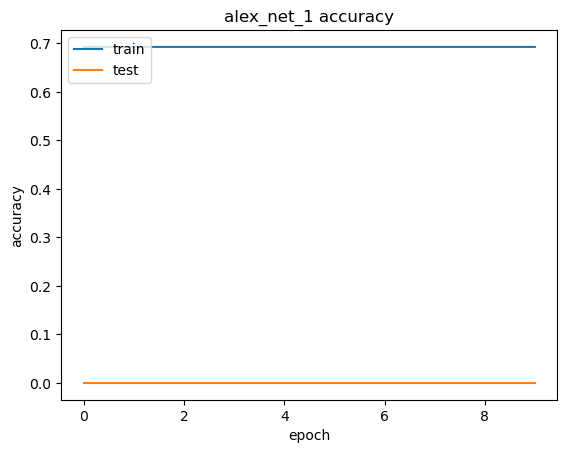

In [24]:
plt.plot(alex_net_1_history.history['accuracy'])
plt.plot(alex_net_1_history.history['val_accuracy'])
plt.title('alex_net_1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
new_model = load_model("alex_net_1_v2.h5")

In [12]:
new_model.evaluate(Test_IMG_Set)

68/68 [==============================] - 12s 169ms/step - loss: 1.0394 - accuracy: 0.1111


[1.0394206047058105, 0.1111111119389534]